# Monkey Functions
- 1.) Make pipeline for predictions
- 2.) Cycle through all the features and make predictions 
- 3.) Make software that allows for the user to enter the following and get preditctions out of it (i.e. train on all data and get novel predictions - dramatic presentation)
    - Age
    - Sex
    - Dose
    - Time since Irradiation
- 4.) Incorporate optimization in the pipeline
- 5.) Pipeline for health outcomes
    - able to cycle through as well

In [3]:
### Using monkey_env/ ###
### If giving a tqb error, run this code twice###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#language handling
#import bert

#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

print("Setup Complete")


Setup Complete


In [4]:
pwd

'/Users/aidanlew/Desktop/cmb/codes/monkey_irrad_sept-2022'

In [5]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [6]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Predicting Biomarker Levels and Health Outcomes

## Data loading

In [7]:
# Make a df of the binary health data of the monkeys
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

minhealth_monkey_df['Animal_Status'] = minhealth_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})
#minhealth_monkey_df.head(15)
minhealth_monkey_df.columns


Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

In [8]:
# See our monkey sample size
print('Total Monkeys:{}'.format(minhealth_monkey_df['ID'].nunique()))
 
# Count the control monkeys
print('Non-Irradiated Monkeys:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[0]))
 
# Count the irradiated monkeys
#print('Irradiated Samples:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[!=0]))



Total Monkeys:152
Non-Irradiated Monkeys:32


In [9]:
#Makee a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Cannot parse header or footer so it will be ignored


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [10]:
#Makee a df were there is one monkey's data missing (the same in the single_monkey_df)
oneless_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
oneless_df.set_index(['ID'])

oneless_df['ID'] = oneless_df['ID'].astype(str)

#oneless_dff.dropna(axis=0, inplace=True) 

#oneless_df.columns
oneless_df.tail()

Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4529,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4530,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4531,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [11]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


# PLOTTING FUNCTION 

In [14]:
def predict_and_plot(model, X_validation, y_validation, y):
    
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)


    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )

    #Plot axis titles
    xlab = input("X axis name:")
    ylab = input("Y axis name:")
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,
                 fontsize=15
    )
    
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    plt.show()

# MODEL FUCTION

In [15]:
def regression_model_formation (X,y,cat_features):
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

# MODEL, PREDICT, AND PLOT FXN

In [17]:
def model_pred_plot (X, y, cat_features, X_validation, y_validation):
    ### Model Formation ###
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)


    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    ### Plotting ###
    
    #Plot axis titles
    xlab = input("X axis name:")
    ylab = input("Y axis name:")
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,
                 fontsize=15
    )
    
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    plt.show()
    

# DATA SETUP FUNCTION

In [18]:
def data_setup (df, cat_features):
    ylabel = input('Target Feature Column')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    test_size = float(input('Test Size'))
    
    (train_df, test_df)= df, df
   
    cat_features= list(range(0,X[X.columns[:1]].shape[1]))
   

    #put the data into the pool
    pool = Pool(data=X, label=y, cat_features=cat_features)

    #train tesr split - 30% test
    data= train_test_split(X, y, test_size=0.3, random_state=0)

    #### The order of this matters###
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )

# PIPELINE FOR REGRESSION


In [57]:
def regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,
              cat_features=cat_features,
              verbose=False
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

   
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    
    plt.show() 
    
    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    

# HEALTH OUTCOME PIPELINE

In [ ]:
def classifier_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostClassifier(iterations=iterations, 
                              learning_rate=learning_rate,
                               loss_function='Logloss',
                               custom_loss=['AUC','Accuracy'],
                               early_stopping_rounds= early_stopping_rounds
    )
   

    model.fit(X, y, 
              cat_features=cat_features, 
              verbose=False  
    )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

    ### Plotting ###
    # make confusion matrix
    cm = confusion_matrix(y_validation, a_df)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  #display_labels=clf.classes_
                                 )
    
    disp.plot()
    plt.grid(False)


    Accuracy = metrics.accuracy_score(y_validation, a_df)
    Precision = metrics.precision_score(y_validation, a_df)

    print('Accuracy:',Accuracy, 'Precision:',Precision)
    print(classification_report(y_validation, a_df))

# Single Monkey Preditions, whole data

In [20]:
#make a parent df
single_minbio_df.copy()
sreg_df = single_minbio_df

#Exclude datetime feautres
sreg_df=sreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
sreg_df.head(2)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,Yes,F,Clinical,1303.0,43.0,81.0,1.14,10.3,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,Yes,F,Clinical,1344.0,44.0,81.0,1.14,10.4,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


Target Feature Column: AGE
How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 10
Learning Rate: 0.5
Stopping Rounds: 5


0:	learn: 1.0340601	total: 57.3ms	remaining: 516ms
1:	learn: 0.9007120	total: 58.3ms	remaining: 233ms
2:	learn: 0.7933681	total: 58.8ms	remaining: 137ms
3:	learn: 0.6923255	total: 59.3ms	remaining: 88.9ms
4:	learn: 0.5890139	total: 59.7ms	remaining: 59.7ms
5:	learn: 0.4696462	total: 60ms	remaining: 40ms
6:	learn: 0.3966370	total: 60.4ms	remaining: 25.9ms
7:	learn: 0.3468795	total: 60.8ms	remaining: 15.2ms
8:	learn: 0.3029984	total: 61.2ms	remaining: 6.8ms
9:	learn: 0.2579198	total: 61.6ms	remaining: 0us


Plot Title: Age


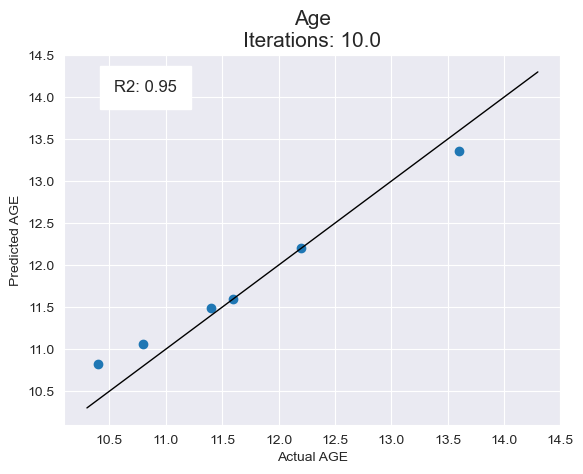

                                           Feature Id  Importances
0                                    DAYS_SINCE_IRRAD    23.272101
1                                  MONTHS_SINCE_IRRAD    17.178474
2                                     ABS_LYMPH_(/uL)    16.158335
3                               Hemaglobin_(HGB_g/dL)     8.551944
4                                                TYPE     8.229269
5                Mean_corpuscular_hemaglobin_(MCH_pg)     8.005325
6                                     LYMPHOCYTES_(%)     5.446214
7                                          WBC_(K/uL)     4.609653
8                                             EOS_(%)     2.790546
9                                    Hemocrit_(HCT_%)     2.551248
10                   Mean_corpuscular_volume_(MCV_fL)     1.620878
11                                           BASO_(%)     0.852428
12                                     ABS_NEUT_(/uL)     0.238839
13                                      ABS_EOS_(/uL)     0.19

In [21]:
regression_pipeline (sreg_df)

# Multi Monkey Predictions, whole data

In [182]:
#make a parent df
minbio_monkey_df.copy()
mreg_df = minbio_monkey_df

#Exclude datetime feautres
mreg_df=mreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
mreg_df.head(2)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,NaN,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 10
Learning Rate: 0.5
Stopping Rounds: 5


0:	learn: 8.9546285	total: 5.74ms	remaining: 51.6ms
1:	learn: 5.6638343	total: 10.4ms	remaining: 41.8ms
2:	learn: 4.0121201	total: 15.2ms	remaining: 35.4ms
3:	learn: 3.0209193	total: 19.6ms	remaining: 29.4ms
4:	learn: 2.5326614	total: 24.3ms	remaining: 24.3ms
5:	learn: 2.2299779	total: 29.6ms	remaining: 19.7ms
6:	learn: 2.0293479	total: 34.2ms	remaining: 14.7ms
7:	learn: 1.9160268	total: 36.9ms	remaining: 9.22ms
8:	learn: 1.8753615	total: 39.5ms	remaining: 4.38ms
9:	learn: 1.7568019	total: 42.1ms	remaining: 0us


Plot Title: Multi monkey lymphocytes


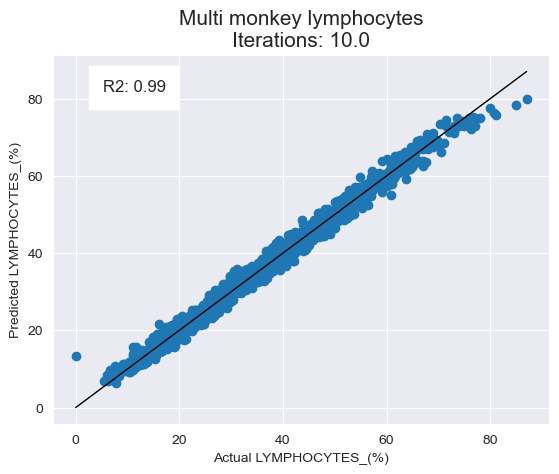

                                           Feature Id  Importances
0                                            NEUT_(%)    86.690265
1                                     ABS_LYMPH_(/uL)     4.309505
2                                      ABS_MONO_(/uL)     2.908496
3                                            MONO_(%)     2.536824
4                                             EOS_(%)     1.749061
5                                       ABS_EOS_(/uL)     0.948118
6                               Hemaglobin_(HGB_g/dL)     0.429481
7                                      ABS_NEUT_(/uL)     0.275921
8                                    Hemocrit_(HCT_%)     0.072630
9                    Mean_corpuscular_volume_(MCV_fL)     0.037872
10                                           BASO_(%)     0.034285
11  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.007542
12                                            Species     0.000000
13                                              IRRAD     0.00

In [186]:
regression_pipeline(mreg_df)


## Prediction of biomarkers

### A. Predictions using only the top 5 important features
top 5 features found in section 1.a. Using the top 5 features found from each model (single v. multi monkey)

#### Single Monkey:
Top 5 features: 
- 0 NEUT_(%)	26.502043
- 1	TYPE	12.952220
- 2	ABS_LYMPH_(/uL)	12.820068
- 3	EOS_(%)	11.754037
- 4	RBC_(M/uL)	11.554449


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 1


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 2
Learning Rate: 0.5
Stopping Rounds: 1


0:	learn: 10.8658171	total: 332us	remaining: 332us
1:	learn: 8.3596623	total: 836us	remaining: 0us


Plot Title: Lymph


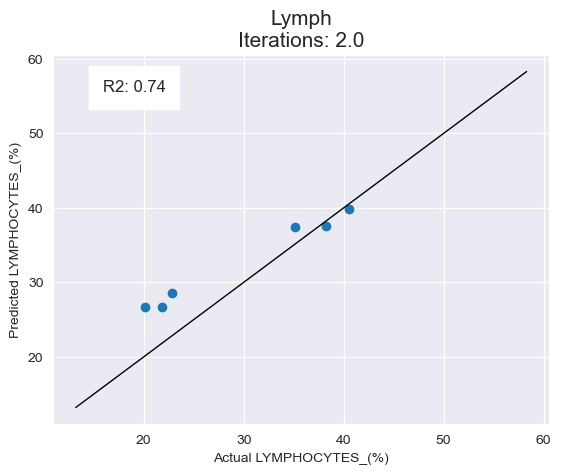

        Feature Id  Importances
0         NEUT_(%)    80.213888
1  ABS_LYMPH_(/uL)     8.849107
2          EOS_(%)     7.721027
3             TYPE     3.215977
4       RBC_(M/uL)     0.000000


In [48]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
sred_reg_df = single_minbio_df[['ID', 'TYPE', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','RBC_(M/uL)', 'LYMPHOCYTES_(%)']]
regression_pipeline(sred_reg_df)

#### Multi Monkey
Top 5 features:
- 0 NEUT_(%)	92.324836
- 1	ABS_LYMPH_(/uL)	3.185803
- 2	ABS_MONO_(/uL)	2.682848
-  3	EOS_(%)	1.198216
- 4	Hemaglobin_(HGB_g/dL)	0.559005

Also try with just NEUT_(%) since it is so heavily weighted

Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 2
Learning Rate: 0.5
Stopping Rounds: 1


0:	learn: 8.8298096	total: 1.65ms	remaining: 1.65ms
1:	learn: 5.6820389	total: 4.25ms	remaining: 0us


Plot Title: Multi Monkey 5 Features


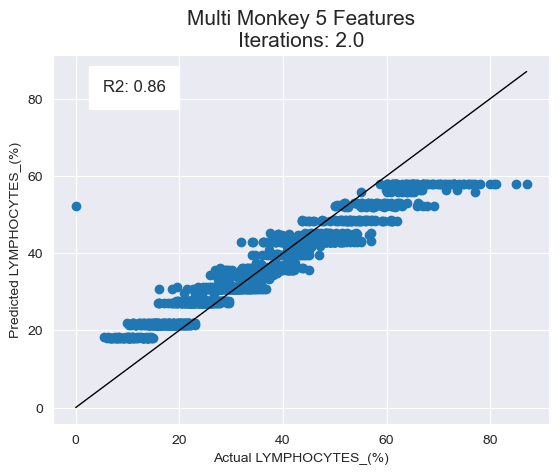

              Feature Id  Importances
0               NEUT_(%)    94.505935
1        ABS_LYMPH_(/uL)     5.294105
2  Hemaglobin_(HGB_g/dL)     0.199960
3         ABS_MONO_(/uL)     0.000000
4                EOS_(%)     0.000000


In [50]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mred_reg_df = minbio_monkey_df[['ID', 'ABS_MONO_(/uL)', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','Hemaglobin_(HGB_g/dL)', 'LYMPHOCYTES_(%)']]


regression_pipeline(mred_reg_df)


### B. Predicting lymphocytes with only the irradiation data


#### Multi Monkey only
No variation for single monkey model formation

In [53]:
mrad_reg_df

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
0,2061,No,F,NaN,NaN,NaN,NaN,10.6,48.0
1,2061,No,F,NaN,NaN,NaN,NaN,10.7,21.4
2,2061,No,F,NaN,NaN,NaN,NaN,10.9,8.5
3,2061,No,F,NaN,NaN,NaN,NaN,11.3,5.5
4,2061,No,F,NaN,NaN,NaN,NaN,11.6,14.5
...,...,...,...,...,...,...,...,...,...
4547,2112,No,M,NaN,NaN,NaN,NaN,21.0,67.0
4548,2112,No,M,NaN,NaN,NaN,NaN,21.4,56.1
4549,2210,No,F,NaN,NaN,NaN,NaN,25.5,26.8
4550,2210,No,F,NaN,NaN,NaN,NaN,25.5,36.2


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 2


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 2
Learning Rate: 0.5
Stopping Rounds: 1


0:	learn: 14.8524382	total: 1.92ms	remaining: 1.92ms
1:	learn: 14.5519045	total: 3.57ms	remaining: 0us


Plot Title: multi monkey irradiation only


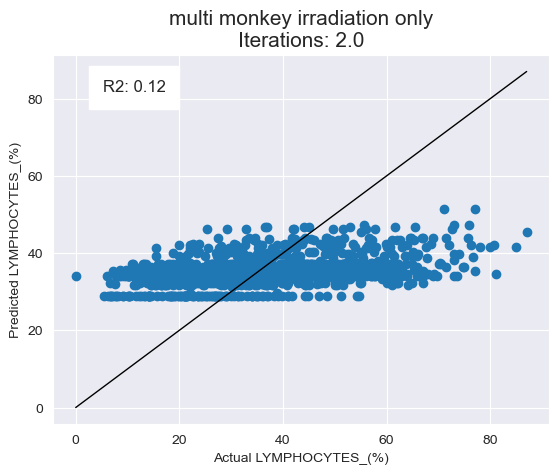

           Feature Id  Importances
0                 AGE    48.693144
1                 SEX    22.237454
2    DAYS_SINCE_IRRAD    16.829884
3           DOSE_(Gy)    11.633621
4  MONTHS_SINCE_IRRAD     0.605897
5               IRRAD     0.000000
6     MONTHS AT IRRAD     0.000000


In [56]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mrad_reg_df = minbio_monkey_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]


regression_pipeline(mrad_reg_df)


#### single monkey only

In [83]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
srad_reg_df = single_minbio_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
srad_reg_df.tail(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
49,2046,Yes,F,2570.0,84.0,81.0,1.14,13.8,58.3
50,2046,Yes,F,2738.0,90.0,81.0,1.14,14.3,52.8


In [84]:
### Process data for ML
#make train/testdf
(srad_reg_train_df, srad_reg_test_df)= srad_reg_df, srad_reg_df


# label values extraction
srad_reg_y=srad_reg_train_df['LYMPHOCYTES_(%)']
srad_reg_X=srad_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,srad_reg_X[srad_reg_X.columns[:2]].shape[1]))

print(cat_features)


#put the data into the pool
srad_reg_pool = Pool(data=srad_reg_X, label=srad_reg_y, cat_features=cat_features)


#train tesr split - 30% test
srad_reg_data= train_test_split(srad_reg_X, srad_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
srad_reg_X_train, srad_reg_X_validation, srad_reg_y_train, srad_reg_y_validation= srad_reg_data

srad_reg_train_pool = Pool(
    data = srad_reg_X_train,
    label = srad_reg_y_train,
    cat_features = cat_features
)

srad_reg_validation_pool = Pool(
    data = srad_reg_X_validation,
    label = srad_reg_y_validation,
    cat_features = cat_features
)



[0, 1]


iteritems is deprecated and will be removed in a future version. Use .items instead.


6


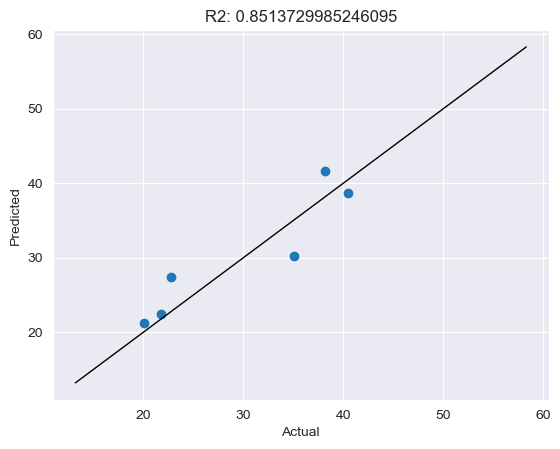

In [85]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 1000 iteration, 0.5 learning rate

smrad_reg_a = model12.predict(srad_reg_X_validation)
print(len(smrad_reg_a), 
     )
smrad_reg_a_df = pd.DataFrame(smrad_reg_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(srad_reg_y_validation, smrad_reg_a_df)


ax.plot([srad_reg_y.min(), srad_reg_y.max()], [srad_reg_y.min(), srad_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(srad_reg_y_validation, smrad_reg_a_df)))

plt.show()

## Predictions of the health outcomes
Doesn't make sense to predict or use single monkey moels/data becuase there is only one observation per monkey

In [29]:
minhealth_monkey_df.head(2)

,ID,Time_Under_Observation_(yrs),Dose_(Gy),Irrad_Age_(months),Years_Since_Irrad,Current_Age_(years),Animal_Status,Diabetes_(Y/N),Cataracts_(Y/N),Arthritis_(Y/N),...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,1423,1.380822,0.0,NaN,NaN,9.947945,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1484,11.868493,0.0,NaN,NaN,19.276712,1,0,1,1,...,0,0,0,0,0,1,0,1,0,0


### A. Multi Monkey using only top 5 features
- 0. Dose_(Gy)	14.984810
- 1	Heart_(Y/N)	14.908153
- 2	Time_Under_Observation_(yrs)	13.851867
- 3	Overweight_(Y/N)	11.484527
- 4	Years_Since_Irrad	11.038610

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 100
Learning Rate: 0.5
Stopping Rounds: 1


Accuracy: 0.9565217391304348 Precision: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        37
           1       0.89      0.89      0.89         9

    accuracy                           0.96        46
   macro avg       0.93      0.93      0.93        46
weighted avg       0.96      0.96      0.96        46



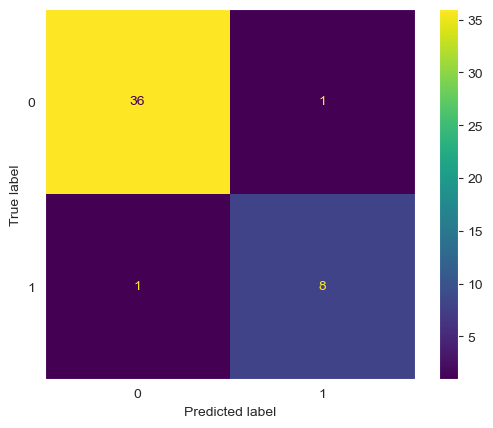

In [68]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
five_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Heart_(Y/N)', 'Time_Under_Observation_(yrs)',
                                'Overweight_(Y/N)','Years_Since_Irrad', 'Tumor_(Y/N)']]

classifier_pipeline (five_health_df)

### B. Multi monkey with only the radiation data

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 200
Learning Rate: 0.5
Stopping Rounds: 5


Accuracy: 1.0 Precision: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00         9

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



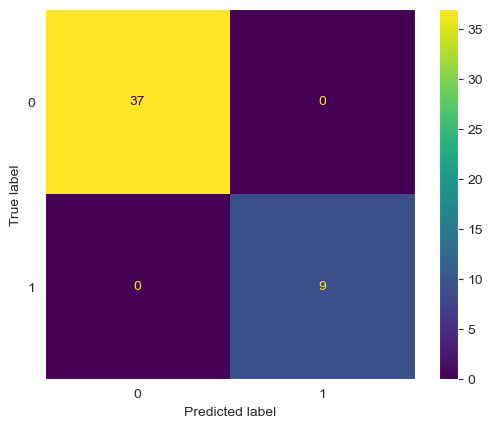

In [45]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
rad_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Irrad_Age_(months)',
                                           'Years_Since_Irrad', 'Current_Age_(years)', 'Tumor_(Y/N)']]

classifier_pipeline (rad_health_df)

Target Feature Column: Testicular Atrophy_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 200
Learning Rate: 0.5
Stopping Rounds: 5


Accuracy: 1.0 Precision: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        25

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



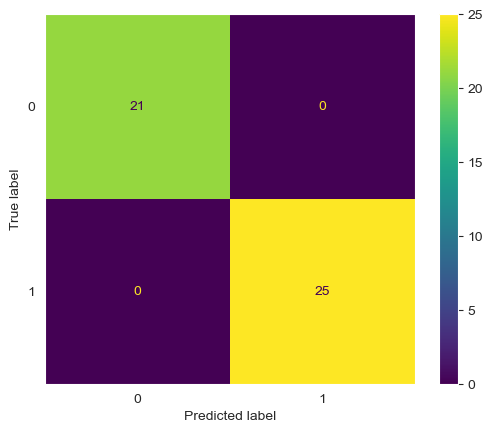

In [47]:
minhealth_monkey_df.head()

classifier_pipeline (minhealth_monkey_df)

## Predicting dose 

In [59]:
#make single monkey
single_minbio_df.copy()
single_dose_df = single_minbio_df

#fill na values to 0
single_dose_df[['DOSE_(Gy)']]= single_dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)



#make multi monkey df
minbio_monkey_df.copy()
dose_df = minbio_monkey_df

#fill na values to 0
dose_df[['DOSE_(Gy)']]= dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)

dose_df['DOSE_(Gy)']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64

In [63]:
dose_df = dose_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)

Target Feature Column: DOSE_(Gy)
How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 100
Learning Rate: 0.5
Stopping Rounds: 1
Plot Title: dose


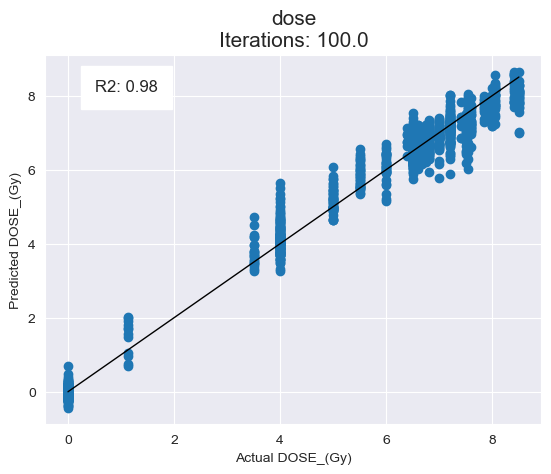

                                           Feature Id  Importances
0                                     MONTHS AT IRRAD    78.373332
1                                  MONTHS_SINCE_IRRAD     4.828723
2                                    DAYS_SINCE_IRRAD     2.651864
3                                                 SEX     2.217122
4                                                 AGE     1.883568
5                Mean_corpuscular_hemaglobin_(MCH_pg)     1.730285
6                                    Hemocrit_(HCT_%)     1.326405
7                    Mean_corpuscular_volume_(MCV_fL)     0.835481
8                                PLATLET_COUNT_(K/uL)     0.768381
9   Mean_corpuscular_hemaglobin_concentration_(MCH...     0.746726
10                                            Species     0.718196
11                              Hemaglobin_(HGB_g/dL)     0.715697
12                                         RBC_(M/uL)     0.644539
13                                     ABS_MONO_(/uL)     0.52

In [67]:
regression_pipeline(dose_df)

# Cycle through the different features

In [70]:
minbio_monkey_df.head(2)


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,2017-12-20,No,NaT,2007-05-14,F,Clinical,NaN,NaN,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,2018-01-29,No,NaT,2007-05-14,F,Research,NaN,NaN,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [123]:
def cycle_feature_regression_predictions (df):
    
    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:     
            ### Data Setup ###

            (train_df, test_df)= df, df 

            #data labeling
            ylabel = columnName
            y = df[ylabel]
            X = df.drop(['ID',ylabel],axis=1)

            #declare catagorical features
            cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

            #put data into pool
            pool = Pool(data=X, label=y, cat_features=cat_features)

            #train tesr split
            #test_size = float(input('Test Size'))
            test_size = 0.3
            data= train_test_split(X, y, test_size=test_size, random_state=0)

            #The order of this matters#
            X_train, X_validation, y_train, y_validation= data

            train_pool = Pool(
                data = X_train,
                label = y_train,
                cat_features = cat_features
            )


            validation_pool = Pool(
                data = X_validation,
                label = y_validation,
                cat_features = cat_features
            )

            ### Model Formation ###
            #iterations = float(input('Iterations:'))
            #learning_rate = float(input('Learning Rate:'))
            #early_stopping_rounds = float(input('Stopping Rounds:'))
            iterations = 10
            learning_rate = 0.5
            early_stopping_rounds = 2


            model = CatBoostRegressor(iterations=iterations, 
                                      learning_rate=learning_rate,
                                       early_stopping_rounds= early_stopping_rounds
                                     )
            model.fit(X,y,
                      cat_features=cat_features,
                      verbose=False
                 )

            ### Predictions ###
            a = model.predict(X_validation)
            a_df = pd.DataFrame(a)


            ### Plotting ###
            # Plot the predictions
            fig, ax = plt.subplots()
            ax.scatter(y_validation, a_df)

            ax.plot([y.min(), y.max()], [y.min(), y.max()], 
                    'k-', 
                    linewidth=1, 
                    markersize=120
            )

            #Plot axis titles
            ax.set_xlabel('Actual {}'.format(str(ylabel)))
            ax.set_ylabel('Predicted {}'.format(str(ylabel)))

            #Title of the plot
            #plot_title = input("Plot Title:")
            show_iters = model.get_param('iterations')  
            ax.set_title(ylabel + "\nIterations: {}".format(str(show_iters))
                         ,fontsize=15
            )

            #cordinates for the R2 value box
            xmin, xmax, ymin, ymax = plt.axis()
            yrange = ymax-ymin
            xrange = xmax-xmin


            #Plotting the R2 score
            ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
                        xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
                        fontsize=12,
                        bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
            )

            plt.show() 

            ### Feature Importance ###

            feat = model.get_feature_importance(data=pool,
                               prettified=True,

            )

            print(feat)


In [84]:
cyclebio_df.head(2)

,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,0.0,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,0.0,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [173]:
def facet (df):

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Biomarker Predictions", fontsize=18, y=0.95)

    # set number of columns (use 3 to demonstrate the change)
    ncols = 6

    # calculate number of rows
    #nrows = len(tickers) // ncols + (len(tickers) % ncols > 0)
    nrows = 5
    n = 0 
   



    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:        
            n=n+1
            # add a new subplot iteratively using nrows and cols
            
            
            ax = plt.subplot(nrows, ncols, n+1 )
            ax.scatter(df[columnName],df[columnName])

    

            # filter df and plot ticker on the new subplot axis
            df[columnName].plot((df[columnName],df[columnName]),ax=ax)

            # chart formatting
            ax.set_title(columnName.upper())
            #ax.get_legend().remove()
            ax.set_xlabel("")

How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind=(0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64, 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64))` instead of `Series.plot((0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64, 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64),)`.

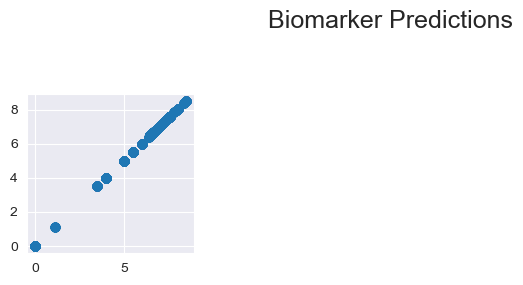

In [174]:
facet (cyclebio_df)

How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


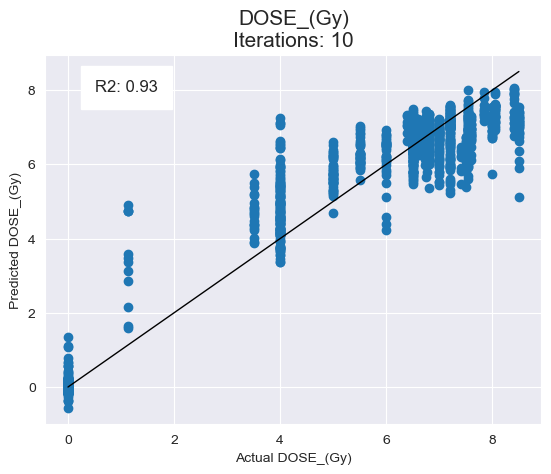

                                           Feature Id  Importances
0                                     MONTHS AT IRRAD    83.477958
1                                  MONTHS_SINCE_IRRAD     4.827549
2                                    DAYS_SINCE_IRRAD     2.491006
3                                                 SEX     1.926442
4                                                 AGE     1.588837
5                Mean_corpuscular_hemaglobin_(MCH_pg)     1.127448
6                                    Hemocrit_(HCT_%)     1.126937
7                                             Species     0.646055
8                               Hemaglobin_(HGB_g/dL)     0.638346
9                    Mean_corpuscular_volume_(MCV_fL)     0.446206
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.396374
11                               PLATLET_COUNT_(K/uL)     0.273773
12                                     ABS_MONO_(/uL)     0.242848
13                                         WBC_(K/uL)     0.19

iteritems is deprecated and will be removed in a future version. Use .items instead.


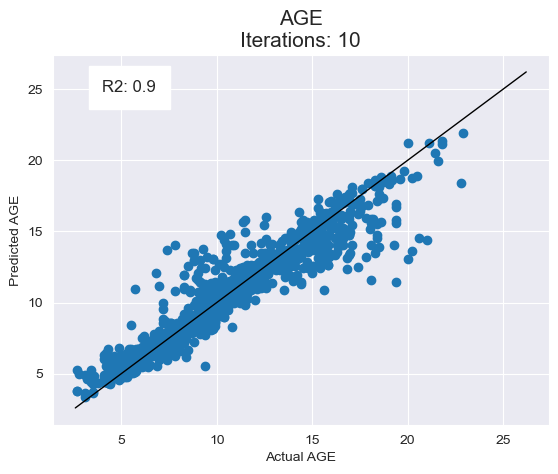

                                           Feature Id  Importances
0                                           DOSE_(Gy)    27.861389
1                                    DAYS_SINCE_IRRAD    18.850529
2                                     MONTHS AT IRRAD    16.374935
3                                  MONTHS_SINCE_IRRAD    15.579338
4                                             Species    13.092201
5                                            MONO_(%)     2.247148
6                                    Hemocrit_(HCT_%)     1.621288
7                                                 SEX     1.613403
8                                PLATLET_COUNT_(K/uL)     0.607188
9                                     ABS_LYMPH_(/uL)     0.556864
10                                         WBC_(K/uL)     0.468858
11                                     ABS_MONO_(/uL)     0.345831
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.210700
13                                           NEUT_(%)     0.18

iteritems is deprecated and will be removed in a future version. Use .items instead.


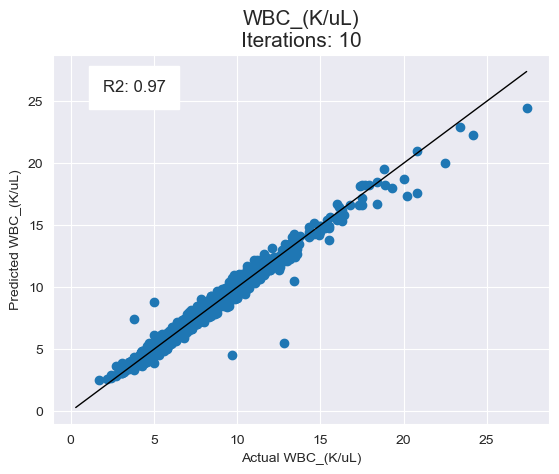

                                           Feature Id  Importances
0                                      ABS_NEUT_(/uL)    73.619382
1                                     ABS_LYMPH_(/uL)    22.605046
2                                      ABS_MONO_(/uL)     1.704593
3                                       ABS_EOS_(/uL)     0.895762
4                                            NEUT_(%)     0.777005
5                                     LYMPHOCYTES_(%)     0.163307
6                                PLATLET_COUNT_(K/uL)     0.091133
7                                                 AGE     0.054187
8                                            MONO_(%)     0.047183
9                                             EOS_(%)     0.021952
10                                           BASO_(%)     0.011471
11                                     ABS_BASO_(/uL)     0.008981
12                                            Species     0.000000
13                                              IRRAD     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


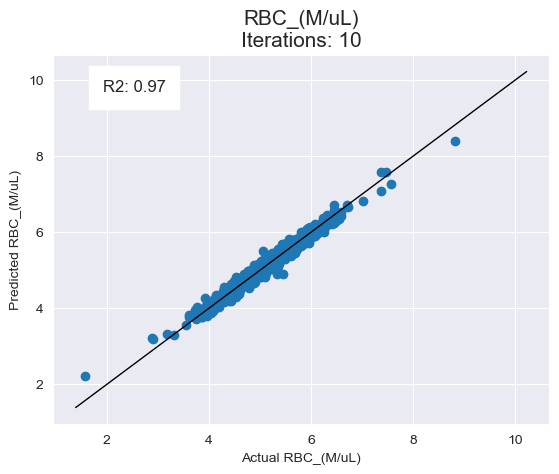

                                           Feature Id  Importances
0                               Hemaglobin_(HGB_g/dL)    34.932942
1                                    Hemocrit_(HCT_%)    34.709964
2                Mean_corpuscular_hemaglobin_(MCH_pg)    21.081137
3                    Mean_corpuscular_volume_(MCV_fL)     9.038050
4                                      ABS_MONO_(/uL)     0.169713
5                                PLATLET_COUNT_(K/uL)     0.026797
6                                       ABS_EOS_(/uL)     0.025853
7                                            BASO_(%)     0.015545
8                                             Species     0.000000
9                                               IRRAD     0.000000
10                                                SEX     0.000000
11                                               TYPE     0.000000
12                                   DAYS_SINCE_IRRAD     0.000000
13                                 MONTHS_SINCE_IRRAD     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


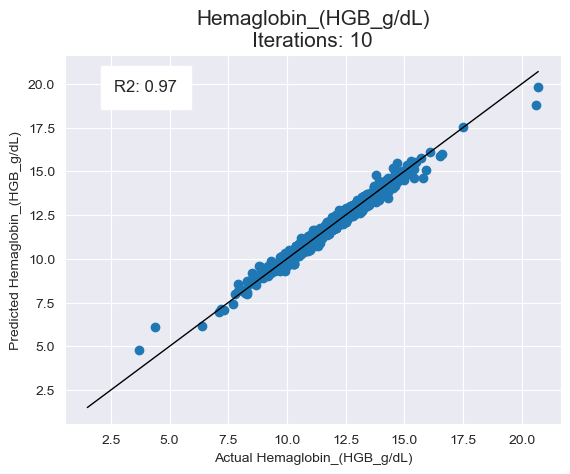

                                           Feature Id  Importances
0                                    Hemocrit_(HCT_%)    76.087768
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    17.107524
2                                          RBC_(M/uL)     4.270028
3                Mean_corpuscular_hemaglobin_(MCH_pg)     1.263716
4                                           DOSE_(Gy)     0.504985
5                                       ABS_EOS_(/uL)     0.284214
6                                      ABS_NEUT_(/uL)     0.250465
7                                            NEUT_(%)     0.126309
8                                      ABS_MONO_(/uL)     0.060478
9                                                 SEX     0.016503
10                                           MONO_(%)     0.012289
11                                    MONTHS AT IRRAD     0.008799
12                                    ABS_LYMPH_(/uL)     0.006923
13                                            Species     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


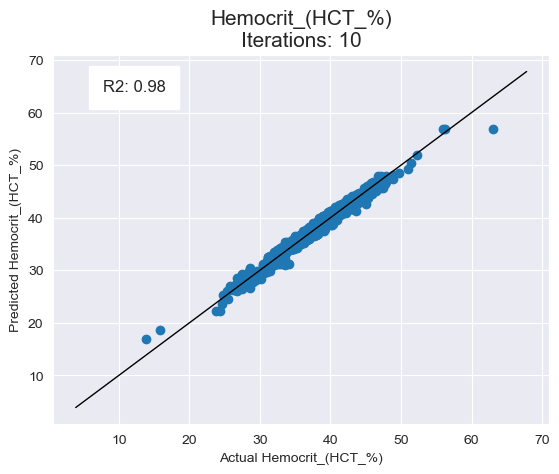

                                           Feature Id  Importances
0                               Hemaglobin_(HGB_g/dL)    83.934975
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    13.958274
2                                          RBC_(M/uL)     1.139059
3                                           DOSE_(Gy)     0.307828
4                                      ABS_MONO_(/uL)     0.216834
5                Mean_corpuscular_hemaglobin_(MCH_pg)     0.197374
6                    Mean_corpuscular_volume_(MCV_fL)     0.118667
7                                     ABS_LYMPH_(/uL)     0.023260
8                                            NEUT_(%)     0.022316
9                                    DAYS_SINCE_IRRAD     0.022215
10                                    MONTHS AT IRRAD     0.019376
11                                    LYMPHOCYTES_(%)     0.018492
12                               PLATLET_COUNT_(K/uL)     0.016764
13                                           MONO_(%)     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


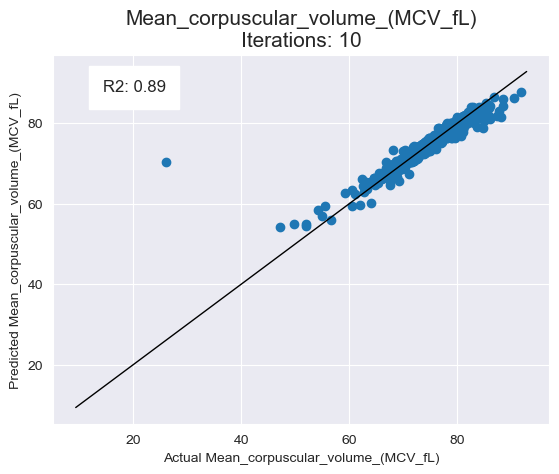

                                           Feature Id  Importances
0                Mean_corpuscular_hemaglobin_(MCH_pg)    64.382210
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    34.101239
2                                    Hemocrit_(HCT_%)     0.745451
3                                  MONTHS_SINCE_IRRAD     0.279317
4                                          WBC_(K/uL)     0.125523
5                                             EOS_(%)     0.103295
6                                     LYMPHOCYTES_(%)     0.073678
7                                          RBC_(M/uL)     0.071530
8                                           DOSE_(Gy)     0.050934
9                               Hemaglobin_(HGB_g/dL)     0.021738
10                                    MONTHS AT IRRAD     0.019844
11                                     ABS_MONO_(/uL)     0.007840
12                                                AGE     0.007626
13                                           MONO_(%)     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


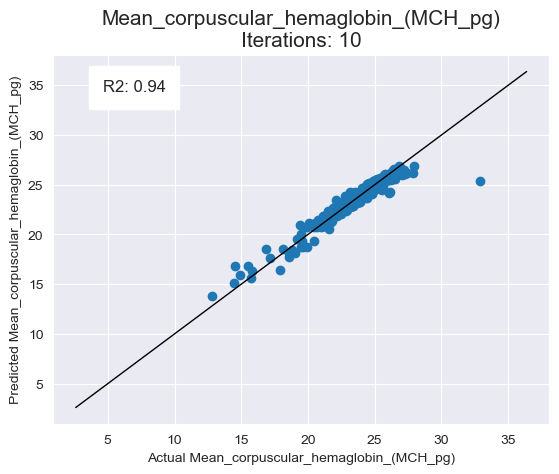

                                           Feature Id  Importances
0                    Mean_corpuscular_volume_(MCV_fL)    59.563497
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    35.490476
2                               Hemaglobin_(HGB_g/dL)     3.638758
3                                             EOS_(%)     0.417951
4                                PLATLET_COUNT_(K/uL)     0.370567
5                                    Hemocrit_(HCT_%)     0.247539
6                                          RBC_(M/uL)     0.104985
7                                                 AGE     0.051502
8                                            NEUT_(%)     0.037692
9                                      ABS_MONO_(/uL)     0.036264
10                                    MONTHS AT IRRAD     0.026345
11                                     ABS_BASO_(/uL)     0.012795
12                                   DAYS_SINCE_IRRAD     0.000596
13                                           BASO_(%)     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


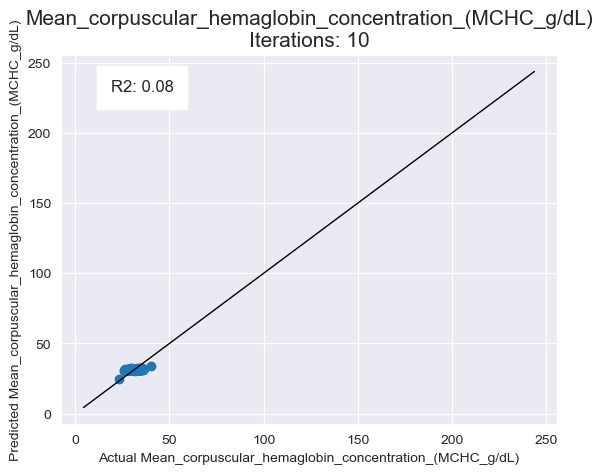

                              Feature Id  Importances
0                       Hemocrit_(HCT_%)    84.942198
1                  Hemaglobin_(HGB_g/dL)    11.213180
2                          ABS_EOS_(/uL)     0.721325
3                        LYMPHOCYTES_(%)     0.447455
4                              DOSE_(Gy)     0.279518
5                        MONTHS AT IRRAD     0.279437
6                         ABS_BASO_(/uL)     0.261614
7                                    AGE     0.257474
8       Mean_corpuscular_volume_(MCV_fL)     0.254370
9                        ABS_LYMPH_(/uL)     0.224186
10                        ABS_MONO_(/uL)     0.218640
11                              MONO_(%)     0.179145
12                              NEUT_(%)     0.162877
13                               EOS_(%)     0.137053
14                        ABS_NEUT_(/uL)     0.119949
15                              BASO_(%)     0.112151
16                  PLATLET_COUNT_(K/uL)     0.065628
17                          

iteritems is deprecated and will be removed in a future version. Use .items instead.


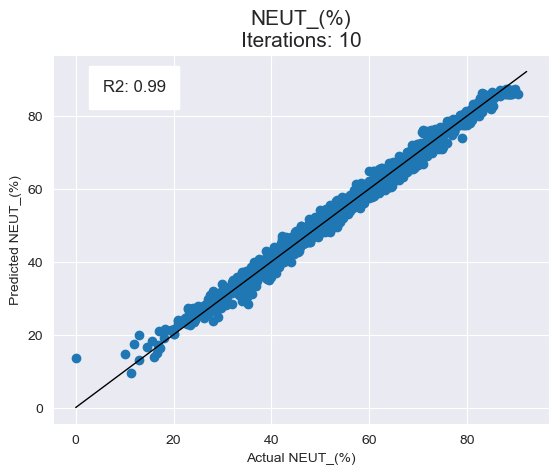

                                           Feature Id  Importances
0                                     LYMPHOCYTES_(%)    83.049482
1                                            MONO_(%)     6.183047
2                                      ABS_NEUT_(/uL)     4.792542
3                                             EOS_(%)     3.355951
4                                       ABS_EOS_(/uL)     1.396763
5                                      ABS_MONO_(/uL)     0.751698
6                                     MONTHS AT IRRAD     0.167322
7                                            BASO_(%)     0.141613
8                                     ABS_LYMPH_(/uL)     0.111344
9                                    Hemocrit_(HCT_%)     0.029229
10                                                SEX     0.015281
11                                     ABS_BASO_(/uL)     0.003801
12                                         RBC_(M/uL)     0.001927
13                                            Species     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


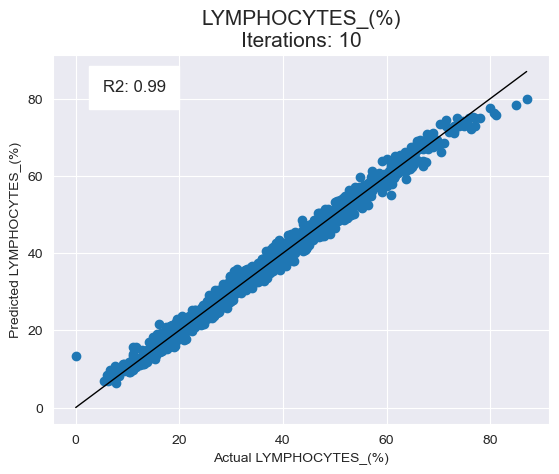

                                           Feature Id  Importances
0                                            NEUT_(%)    86.690265
1                                     ABS_LYMPH_(/uL)     4.309505
2                                      ABS_MONO_(/uL)     2.908496
3                                            MONO_(%)     2.536824
4                                             EOS_(%)     1.749061
5                                       ABS_EOS_(/uL)     0.948118
6                               Hemaglobin_(HGB_g/dL)     0.429481
7                                      ABS_NEUT_(/uL)     0.275921
8                                    Hemocrit_(HCT_%)     0.072630
9                    Mean_corpuscular_volume_(MCV_fL)     0.037872
10                                           BASO_(%)     0.034285
11  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.007542
12                                            Species     0.000000
13                                              IRRAD     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


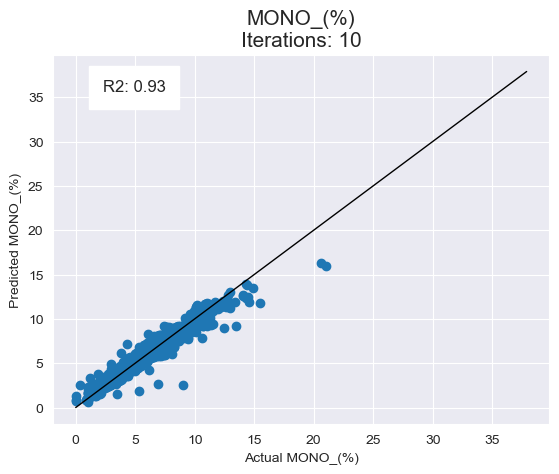

                                           Feature Id  Importances
0                                      ABS_MONO_(/uL)    60.950043
1                                          WBC_(K/uL)    26.527932
2                                      ABS_NEUT_(/uL)     8.470508
3                                     ABS_LYMPH_(/uL)     3.326085
4                                             EOS_(%)     0.525026
5                                PLATLET_COUNT_(K/uL)     0.078973
6                                                 SEX     0.073903
7                                     MONTHS AT IRRAD     0.028464
8   Mean_corpuscular_hemaglobin_concentration_(MCH...     0.012359
9                                    Hemocrit_(HCT_%)     0.003619
10                                   DAYS_SINCE_IRRAD     0.001935
11                                                AGE     0.001114
12                                 MONTHS_SINCE_IRRAD     0.000038
13                                            Species     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


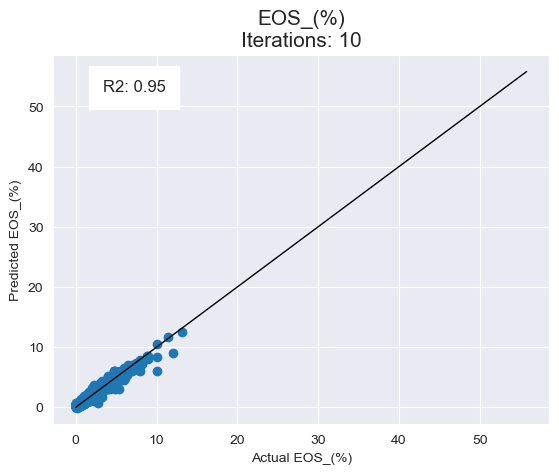

                                           Feature Id  Importances
0                                       ABS_EOS_(/uL)    80.910606
1                                      ABS_NEUT_(/uL)     9.190393
2                                          WBC_(K/uL)     2.617594
3                                     ABS_LYMPH_(/uL)     2.571892
4                Mean_corpuscular_hemaglobin_(MCH_pg)     2.355680
5                                            NEUT_(%)     0.874915
6                                      ABS_MONO_(/uL)     0.481182
7                                  MONTHS_SINCE_IRRAD     0.245002
8                                     MONTHS AT IRRAD     0.243145
9                                    Hemocrit_(HCT_%)     0.165938
10                               PLATLET_COUNT_(K/uL)     0.091463
11                              Hemaglobin_(HGB_g/dL)     0.062282
12                                                AGE     0.060931
13                                     ABS_BASO_(/uL)     0.05

iteritems is deprecated and will be removed in a future version. Use .items instead.


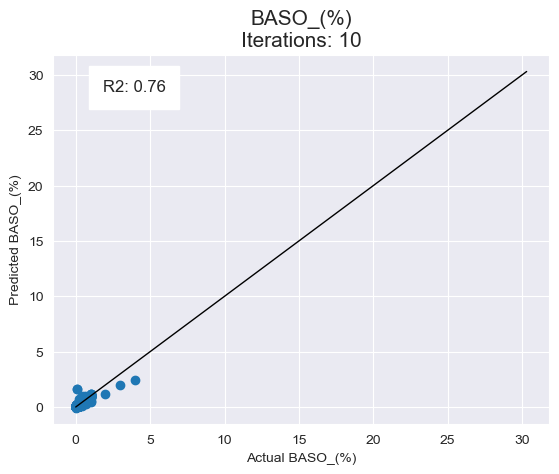

                                           Feature Id  Importances
0                                      ABS_BASO_(/uL)    34.912543
1                                            NEUT_(%)    12.721195
2                Mean_corpuscular_hemaglobin_(MCH_pg)    12.595931
3                                      ABS_NEUT_(/uL)    10.868723
4                                      ABS_MONO_(/uL)     9.617802
5                                     LYMPHOCYTES_(%)     4.327416
6                                     ABS_LYMPH_(/uL)     3.628866
7                                                 AGE     2.587233
8                                            MONO_(%)     2.475271
9   Mean_corpuscular_hemaglobin_concentration_(MCH...     2.336091
10                              Hemaglobin_(HGB_g/dL)     1.955237
11                                      ABS_EOS_(/uL)     1.234001
12                   Mean_corpuscular_volume_(MCV_fL)     0.210799
13                                    MONTHS AT IRRAD     0.16

iteritems is deprecated and will be removed in a future version. Use .items instead.


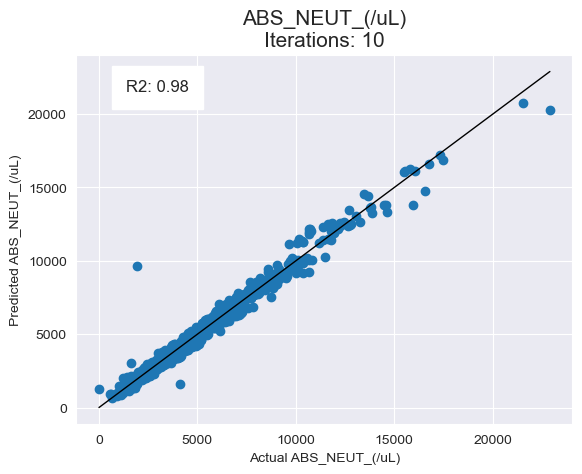

                                           Feature Id  Importances
0                                          WBC_(K/uL)    66.098629
1                                            NEUT_(%)    25.793514
2                                     LYMPHOCYTES_(%)     6.856583
3                                      ABS_MONO_(/uL)     0.646704
4                                     ABS_LYMPH_(/uL)     0.255592
5                                            MONO_(%)     0.245770
6                                    Hemocrit_(HCT_%)     0.021682
7                                             EOS_(%)     0.019967
8                                       ABS_EOS_(/uL)     0.018718
9                    Mean_corpuscular_volume_(MCV_fL)     0.014434
10                                    MONTHS AT IRRAD     0.007600
11                              Hemaglobin_(HGB_g/dL)     0.007358
12                                                SEX     0.007053
13                                         RBC_(M/uL)     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


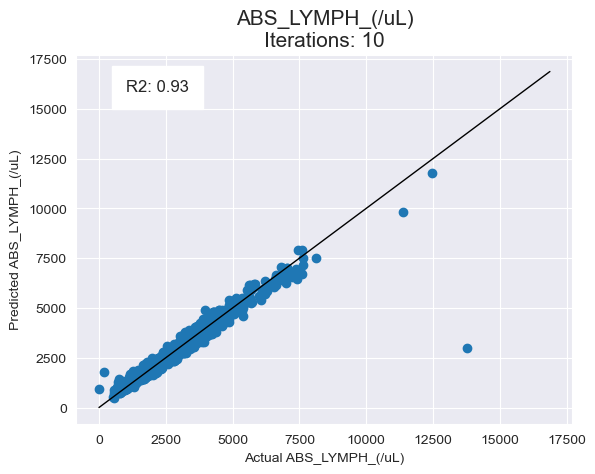

                                           Feature Id  Importances
0                                          WBC_(K/uL)    57.819516
1                                     LYMPHOCYTES_(%)    30.669485
2                                            NEUT_(%)    10.497534
3                                PLATLET_COUNT_(K/uL)     0.262230
4                                      ABS_MONO_(/uL)     0.199354
5                                            MONO_(%)     0.185145
6                                      ABS_NEUT_(/uL)     0.149079
7                                     MONTHS AT IRRAD     0.140187
8                               Hemaglobin_(HGB_g/dL)     0.039261
9                                       ABS_EOS_(/uL)     0.018604
10                                     ABS_BASO_(/uL)     0.013032
11               Mean_corpuscular_hemaglobin_(MCH_pg)     0.003138
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.001624
13                                         RBC_(M/uL)     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


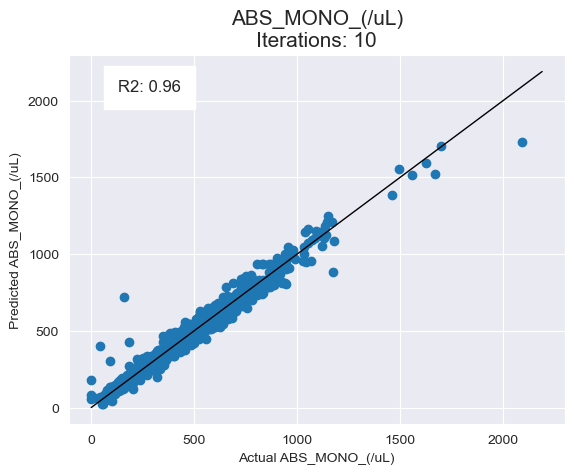

                                           Feature Id  Importances
0                                            MONO_(%)    54.723529
1                                          WBC_(K/uL)    36.440383
2                                      ABS_NEUT_(/uL)     6.971259
3                                     ABS_LYMPH_(/uL)     1.724391
4                                PLATLET_COUNT_(K/uL)     0.071505
5                               Hemaglobin_(HGB_g/dL)     0.058556
6                    Mean_corpuscular_volume_(MCV_fL)     0.010287
7                                          RBC_(M/uL)     0.000090
8                                             Species     0.000000
9                                               IRRAD     0.000000
10                                                SEX     0.000000
11                                               TYPE     0.000000
12                                   DAYS_SINCE_IRRAD     0.000000
13                                 MONTHS_SINCE_IRRAD     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


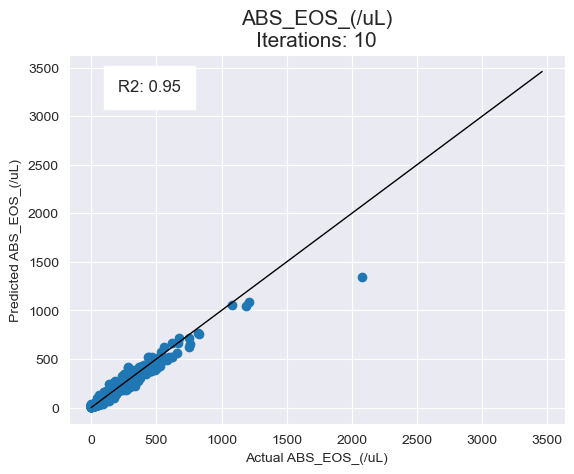

                                           Feature Id  Importances
0                                             EOS_(%)    81.186578
1                                          WBC_(K/uL)    15.709273
2                                     ABS_LYMPH_(/uL)     1.916638
3                                      ABS_MONO_(/uL)     0.531529
4                                                 AGE     0.176816
5   Mean_corpuscular_hemaglobin_concentration_(MCH...     0.151565
6                                    Hemocrit_(HCT_%)     0.120370
7                               Hemaglobin_(HGB_g/dL)     0.084242
8                                            BASO_(%)     0.062135
9                                     MONTHS AT IRRAD     0.039915
10                                     ABS_BASO_(/uL)     0.008694
11                                     ABS_NEUT_(/uL)     0.004822
12                                         RBC_(M/uL)     0.003335
13                                          DOSE_(Gy)     0.00

iteritems is deprecated and will be removed in a future version. Use .items instead.


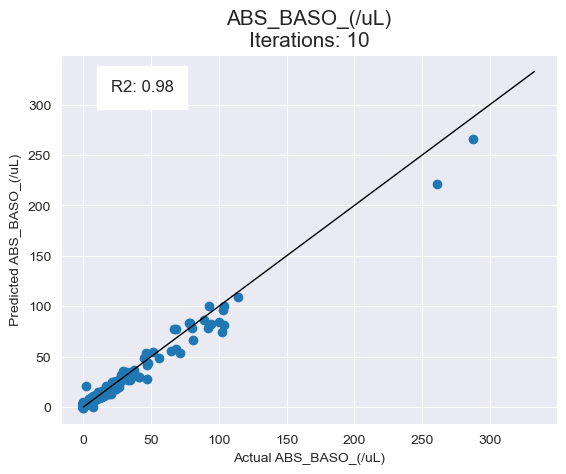

                                           Feature Id  Importances
0                                            BASO_(%)    68.609589
1                                     ABS_LYMPH_(/uL)     8.472352
2                                      ABS_NEUT_(/uL)     7.326641
3                                          WBC_(K/uL)     5.701949
4                                      ABS_MONO_(/uL)     3.168741
5                                     LYMPHOCYTES_(%)     1.495160
6                Mean_corpuscular_hemaglobin_(MCH_pg)     1.028813
7                                            NEUT_(%)     0.940007
8                                PLATLET_COUNT_(K/uL)     0.763487
9                                    Hemocrit_(HCT_%)     0.560960
10                                    MONTHS AT IRRAD     0.380980
11                              Hemaglobin_(HGB_g/dL)     0.332410
12                                                AGE     0.241772
13                                           MONO_(%)     0.22

iteritems is deprecated and will be removed in a future version. Use .items instead.


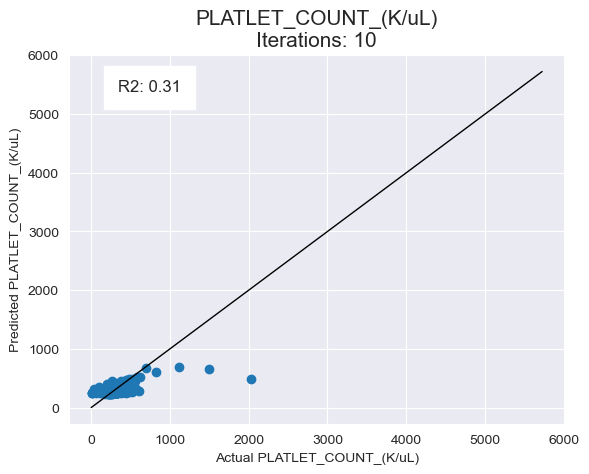

                                           Feature Id  Importances
0   Mean_corpuscular_hemaglobin_concentration_(MCH...    18.088954
1                                                 AGE    12.306791
2                                            MONO_(%)    11.090017
3                                     MONTHS AT IRRAD     8.171903
4                    Mean_corpuscular_volume_(MCV_fL)     6.682226
5                               Hemaglobin_(HGB_g/dL)     5.745958
6                                      ABS_MONO_(/uL)     5.628417
7                                     ABS_LYMPH_(/uL)     4.635827
8                                                 SEX     4.230362
9                                      ABS_BASO_(/uL)     3.111183
10               Mean_corpuscular_hemaglobin_(MCH_pg)     3.068178
11                                   DAYS_SINCE_IRRAD     2.983000
12                                          DOSE_(Gy)     2.798301
13                                 MONTHS_SINCE_IRRAD     2.46

In [124]:
### make a parent df
minbio_monkey_df.copy()
cyclebio_df = minbio_monkey_df

#Exclude datetime feautres
cyclebio_df=cyclebio_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)

cycle_feature_regression_predictions(cyclebio_df)

#4,3,3,3,3,4---